# OBJECTIVE: Build ML algorithm to use text-based clinical literature to classify genetic mutations.

In [64]:
%matplotlib inline

# Data wrapper libraries
import pandas as pd
pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999

import numpy as np

# Visualization Libraries
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.markers import MarkerStyle
import seaborn as sns
color = sns.color_palette()

# Text analysis helper libraries
from gensim.summarization import summarize
from gensim.summarization import keywords

# Text analysis helper libraries for word frequency etc..
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from string import punctuation

# Word cloud visualization libraries
from scipy.misc import imresize
from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator
from collections import Counter

# Word2Vec related libraries
from gensim.models import KeyedVectors

# Dimensionaly reduction libraries
from sklearn.decomposition import PCA

# Clustering library
from sklearn.cluster import KMeans

# Set figure size a bit bigger than default so everything is easily red
plt.rcParams["figure.figsize"] = (11, 7)

C:\Users\mindy\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


ImportError: cannot import name 'imresize' from 'scipy.misc' (C:\Users\mindy\Anaconda3\lib\site-packages\scipy\misc\__init__.py)

In [12]:
tr_txt = pd.read_csv("training_text/training_text", sep="\|\|", engine='python', header=None, skiprows=1, names=["ID","Text"])
test_txt = pd.read_csv("test_text/test_text", sep="\|\|", engine='python', header=None, skiprows=1, names=["ID","Text"])
tr_var = pd.read_csv("training_variants/training_variants")
test_var = pd.read_csv("test_variants/test_variants")

## EDA

In [18]:
tr_txt.head()

,ID,Text
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


In [20]:
#Get a taste of how huge text is attached to 0 ID genetic var
tr_txt['Text'].iloc[0]

"Cyclin-dependent kinases (CDKs) regulate a variety of fundamental cellular processes. CDK10 stands out as one of the last orphan CDKs for which no activating cyclin has been identified and no kinase activity revealed. Previous work has shown that CDK10 silencing increases ETS2 (v-ets erythroblastosis virus E26 oncogene homolog 2)-driven activation of the MAPK pathway, which confers tamoxifen resistance to breast cancer cells. The precise mechanisms by which CDK10 modulates ETS2 activity, and more generally the functions of CDK10, remain elusive. Here we demonstrate that CDK10 is a cyclin-dependent kinase by identifying cyclin M as an activating cyclin. Cyclin M, an orphan cyclin, is the product of FAM58A, whose mutations cause STAR syndrome, a human developmental anomaly whose features include toe syndactyly, telecanthus, and anogenital and renal malformations. We show that STAR syndrome-associated cyclin M mutants are unable to interact with CDK10. Cyclin M silencing phenocopies CDK1

It's huge!! There is a lot of literature to back up a decision on cancer or not, which is a good thing.

In [21]:
test_txt.head()

,ID,Text
0,0,2. This mutation resulted in a myeloproliferat...
1,1,Abstract The Large Tumor Suppressor 1 (LATS1)...
2,2,Vascular endothelial growth factor receptor (V...
3,3,Inflammatory myofibroblastic tumor (IMT) is a ...
4,4,Abstract Retinoblastoma is a pediatric retina...


In [22]:
#Let's see if the same amount of text is in test DF.
test_txt['Text'].iloc[0]

"2. This mutation resulted in a myeloproliferative phenotype, including erythrocytosis, in a murine model of retroviral bone marrow transplantation.  CONCLUSIONS  JAK2 exon 12 mutations define a distinctive myeloproliferative syndrome that affects patients who currently receive a diagnosis of polycythemia vera or idiopathic erythrocytosis.  The myeloproliferative disorders comprise a spectrum of chronic hematologic diseases that are likely to arise from a mutant multipotent hematopoietic stem cell.1,2 The V617F somatic mutation in the Janus kinase (JAK) 2 gene (JAK2), which causes the substitution of phenylalanine for valine at position 617, has recently been found in the majority of patients with polycythemia vera and in many with essential thrombocythemia or idiopathic myelofibrosis.3-7 This gene encodes a cytoplasmic tyrosine kinase. The mutation, which occurs in the JAK homology 2 (JH2) negative regulatory domain, increases JAK2 kinase activity and causes cytokine-independent growt

In [24]:
tr_var.head()

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


In [25]:
test_var.head()

,ID,Gene,Variation
0,0,ACSL4,R570S
1,1,NAGLU,P521L
2,2,PAH,L333F
3,3,ING1,A148D
4,4,TMEM216,G77A


test_var is missing class column which is what the purpose of this analysis is to figure output.

In [26]:
tr_txt.shape, test_txt.shape, tr_var.shape, test_var.shape

((3321, 2), (5668, 2), (3321, 4), (5668, 3))

Test dataset is far larger than training dataset.

Let's look at class distributions and see if there are huge class imbalances. This will affect the accuracy of our prediction classifier.

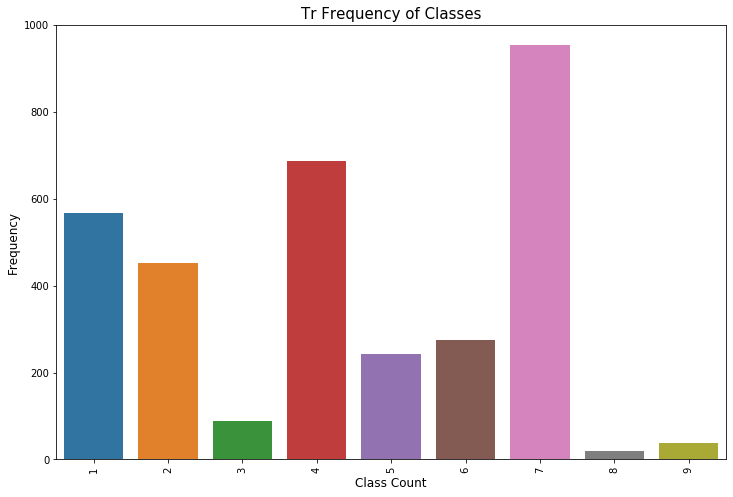

In [59]:
plt.figure(figsize=(12,8))
sns.countplot(x="Class", data=tr_var)
plt.ylabel('Frequency', fontsize=12)
plt.xlabel('Class Count', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Tr Frequency of Classes", fontsize=15)
plt.show()

There is class imbalance. Classes 4 and 7 are the most represented. Whereas classes 3, 8 and 9 are the most under-represented.

No comparison to test dataset is possible since there are no classes given since the objective of the analysis is to predict them using the test dataset.

Now let us look at overall gene distribution.

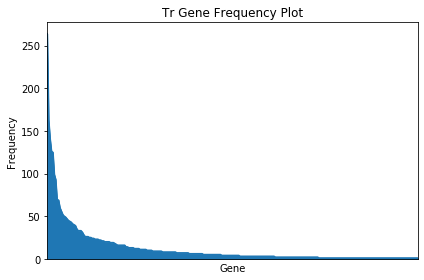

In [57]:
plt.figure()
ax = tr_var['Gene'].value_counts().plot(kind='area')

ax.get_xaxis().set_ticks([])
ax.set_title('Tr Gene Frequency Plot')
ax.set_xlabel('Gene')
ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

Compared to test_var:

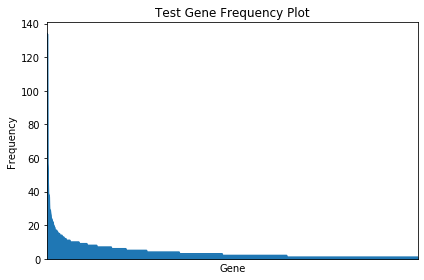

In [58]:
plt.figure()
ax = test_var['Gene'].value_counts().plot(kind='area')

ax.get_xaxis().set_ticks([])
ax.set_title('Test Gene Frequency Plot')
ax.set_xlabel('Gene')
ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

There are not as many clearly dominant genes as seen in trending dataset.

Now, breaking down Trending dataset's gene distribution across classes.

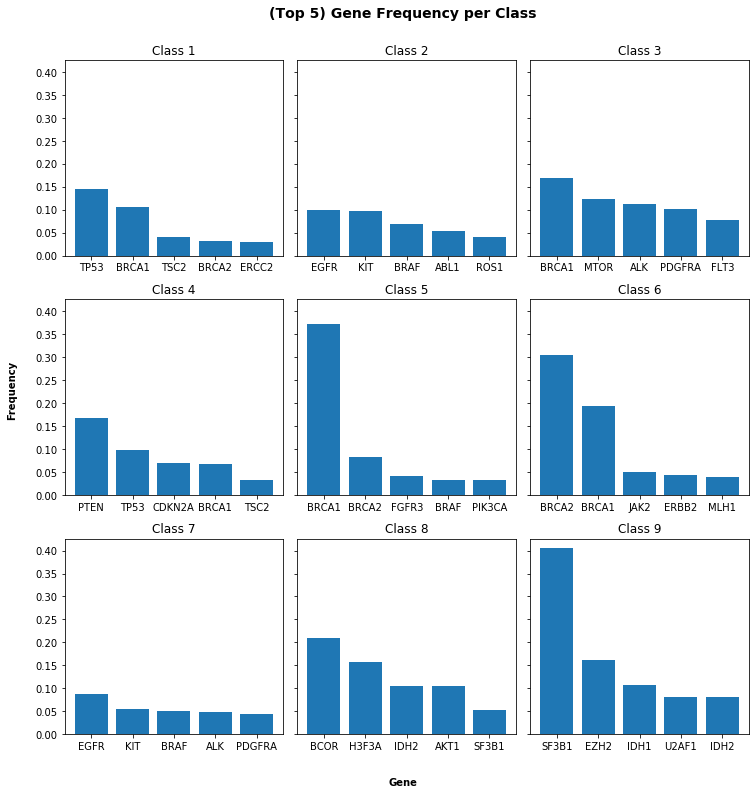

In [54]:
fig, axes = plt.subplots(nrows=3, ncols=3, sharey=True, figsize=(11,11))

# Normalize value counts for better comparison
def normalize_group(x):
    label, repetition = x.index, x
    t = sum(repetition)
    r = [n/t for n in repetition]
    return label, r

for idx, g in enumerate(tr_var.groupby('Class')):
    label, val = normalize_group(g[1]["Gene"].value_counts())
    ax = axes.flat[idx]
    ax.bar(np.arange(5), val[:5],
           tick_label=label[:5]) 
    ax.set_title("Class {}".format(g[0]))
    
fig.text(0.5, 0.97, '(Top 5) Gene Frequency per Class', ha='center', fontsize=14, fontweight='bold')
fig.text(0.5, 0, 'Gene', ha='center', fontweight='bold')
fig.text(0, 0.5, 'Frequency', va='center', rotation='vertical', fontweight='bold')
fig.tight_layout(rect=[0.03, 0.03, 0.95, 0.95])

There are genes in some classes that are the most dominant dwarfing all other genes in the depicted class. This includes Class 5, 6 and 9. Also, another thing to note is BRCA1 and BRCA2 genes appear the most frequently from class to class.

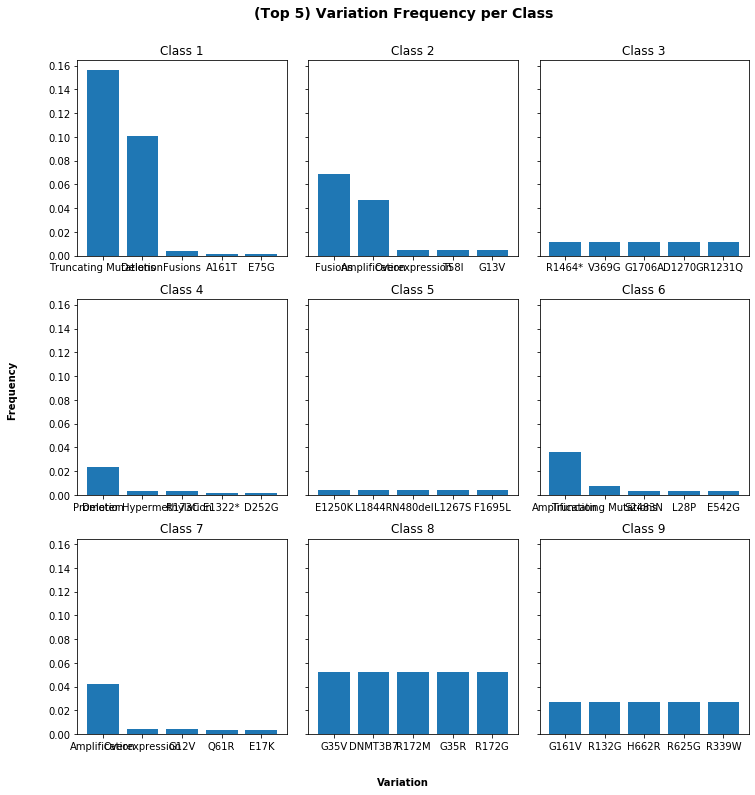

In [56]:
fig, axes = plt.subplots(nrows=3, ncols=3, sharey=True, figsize=(11,11))

# Normalize value counts for better comparison
def normalize_group(x):
    label, repetition = x.index, x
    t = sum(repetition)
    r = [n/t for n in repetition]
    return label, r

for idx, g in enumerate(tr_var.groupby('Class')):
    label, val = normalize_group(g[1]["Variation"].value_counts())
    ax = axes.flat[idx]
    ax.bar(np.arange(5), val[:5],
           tick_label=label[:5]) 
    ax.set_title("Class {}".format(g[0]))
    
fig.text(0.5, 0.97, '(Top 5) Variation Frequency per Class', ha='center', fontsize=14, fontweight='bold')
fig.text(0.5, 0, 'Variation', ha='center', fontweight='bold')
fig.text(0, 0.5, 'Frequency', va='center', rotation='vertical', fontweight='bold')
fig.tight_layout(rect=[0.03, 0.03, 0.95, 0.95])

We can see that in couple of classes that the variation distribution of top 5 are even such as in Classes 3, 5, 8 and 9.

Now checking for NaN's that would affect subsequent analysis.

In [61]:
tr_txt.isnull().sum(), tr_var.isnull().sum(), test_txt.isnull().sum(), test_var.isnull().sum()

(ID      0
 Text    5
 dtype: int64, ID           0
 Gene         0
 Variation    0
 Class        0
 dtype: int64, ID      0
 Text    1
 dtype: int64, ID           0
 Gene         0
 Variation    0
 dtype: int64)

There are 5 in tr_text DF and 1 in test_txt DF. Let us locate them to get some context.

In [62]:
nans = lambda df: df[df.isnull().any(axis=1)]
nans(tr_txt)

,ID,Text
1109,1109,NaN
1277,1277,NaN
1407,1407,NaN
1639,1639,NaN
2755,2755,NaN


In [63]:
nans(test_txt)

,ID,Text
1623,1623,NaN


Need to keep in mind ID's 1109, 1277, 1407, 1639 and 2755 in tr_txt and ID 1623 in test_txt when using any math function for analysis. May need to completely eliminate these from datasets to prevent run barriers.

Now, let us handle the text data and see what sort of insights we can draw from it in order to help in our prediction algorithm. In order to first start doing this, need to first combine the training text DF to the training variant DF. Then we can eliminate the unnecessary columns prior to analyzing the text data. Let's start!

In [65]:
tr_data = pd.concat([tr_var, tr_txt], axis=1)
tr_data.head()

,ID,Gene,Variation,Class,ID,Text
0,0,FAM58A,Truncating Mutations,1,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,CBL,W802*,2,1,Abstract Background Non-small cell lung canc...
2,2,CBL,Q249E,2,2,Abstract Background Non-small cell lung canc...
3,3,CBL,N454D,3,3,Recent evidence has demonstrated that acquired...
4,4,CBL,L399V,4,4,Oncogenic mutations in the monomeric Casitas B...


In [66]:
tr_data['Variation'].describe()

count                     3321
unique                    2996
top       Truncating Mutations
freq                        93
Name: Variation, dtype: object

Variation column mostly unique values, which are not helpful for our prediction. So this will be dropped.

On the other hand, as seen from the Gene column distribution from earlier in the notebook, it is highly skewed. 
Though this can be valuable if it is normalized and balanced by weights. However, in order to not over complicate things for now, this column will be disregarded as well for text analysis.